# Dowload Libraries and Pretrained Weights

In [1]:
import os

! git clone https://www.github.com/matterport/Mask_RCNN.git
! pip install -q silence-tensorflow
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 11.51 MiB/s, done.
Resolving deltas: 100% (558/558), done.
You are using pip version 19.0.3, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import json
import datetime
import numpy as np
import pandas as pd
import skimage
import skimage.draw
from skimage.draw import polygon
import time
import cv2
import matplotlib.pyplot as plt
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from os import listdir
import tensorflow as tf
import random
# ignore warnings to make outputs clearer
import warnings
import skimage
import imageio
import glob
import imgaug
import multiprocessing
import seaborn as sns
from collections import Counter
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mrcnn.model import log

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold


from PIL import Image, ImageDraw
from tqdm import tqdm
from sklearn.model_selection import KFold, train_test_split
from PIL import Image, ImageEnhance
from mrcnn import visualize
import sys
from IPython.display import FileLink
from imgaug import augmenters as iaa
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

warnings.filterwarnings('ignore')
tqdm.pandas()

DATA_DIR = Path('/kaggle/input/')
ROOT_DIR = Path('/kaggle/working/')

print(f'Python Version: {sys.version}')
print(f'Tensorflow Version: {tf.__version__}')
print(f'Tensorflow Keras Version: {tf.keras.__version__}')

Using TensorFlow backend.


Python Version: 3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]
Tensorflow Version: 1.13.1
Tensorflow Keras Version: 2.2.4-tf


In [3]:
sys.path.append(ROOT_DIR/'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [4]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-r--r-- 1 root root 246M Dec  6  2021 mask_rcnn_coco.h5


# Dataset pre-processing

In [5]:
train_df = pd.read_csv('/kaggle/input/deepfashion2-input-dataframes/train.csv')
validation_df = pd.read_csv('/kaggle/input/deepfashion2-input-dataframes/validation.csv')

In [6]:
# Minor pre-processing
train_df['path'] = train_df['path'].str.replace('working', 'input/deepfashion2-256x256')
validation_df['path'] = validation_df['path'].str.replace('working', 'input/deepfashion2-256x256')

In [7]:
validation_df['segmentation'] = validation_df['segmentation'].progress_apply(lambda x: json.loads(x.replace("'", "\"")))
train_df['segmentation'] = train_df['segmentation'].progress_apply(lambda x: json.loads(x.replace("'", "\"")))

validation_df['b_box'] = validation_df['b_box'].progress_apply(lambda x: json.loads(x.replace("'", "\"")))
train_df['b_box'] = train_df['b_box'].progress_apply(lambda x: json.loads(x.replace("'", "\"")))

100%|██████████| 312186/312186 [00:02<00:00, 118545.67it/s]


In [8]:
display(train_df.tail())
print("\n\n")
display(validation_df.tail())

path    ...    img_width
312181  /kaggle/input/deepfashion2-256x256/resized/tra...    ...          256
312182  /kaggle/input/deepfashion2-256x256/resized/tra...    ...          256
312183  /kaggle/input/deepfashion2-256x256/resized/tra...    ...          256
312184  /kaggle/input/deepfashion2-256x256/resized/tra...    ...          256
312185  /kaggle/input/deepfashion2-256x256/resized/tra...    ...          256

[5 rows x 12 columns]

path    ...    img_width
52485  /kaggle/input/deepfashion2-256x256/resized/val...    ...          256
52486  /kaggle/input/deepfashion2-256x256/resized/val...    ...          256
52487  /kaggle/input/deepfashion2-256x256/resized/val...    ...          256
52488  /kaggle/input/deepfashion2-256x256/resized/val...    ...          256
52489  /kaggle/input/deepfashion2-256x256/resized/val...    ...          256

[5 rows x 12 columns]

## Sampling the dataset

In [9]:
def balanced_sampling(df, n_samples_per_category):
    # Store which images (by path) have been sampled
    sampled_images = set()
    
    # Output dataframe to store sampled rows
    sampled_df = pd.DataFrame()

    # Loop over categories
    for category in df['category_name'].unique():
        # Find unique images containing this category
        category_images = set(df[df['category_name'] == category]['path'].unique())
        
        # Exclude already sampled images to ensure new samples
        available_images = category_images - sampled_images
        if len(available_images) < n_samples_per_category:
            selected_images = available_images
        else:
            selected_images = set(np.random.choice(list(available_images), size=n_samples_per_category, replace=False))
        
        # Add selected images to the sampled_images set
        sampled_images = sampled_images.union(selected_images)

        # Gather all rows related to the selected images and append to sampled_df
        sampled_df = pd.concat([sampled_df, df[df['path'].isin(selected_images)]], axis=0)

    return sampled_df.sample(frac=1).reset_index(drop=True)  # shuffle and return

In [10]:
train_df = balanced_sampling(train_df, 1300) #1320
validation_df = balanced_sampling(validation_df, 1500) #400

In [11]:
grouped_train = train_df.groupby('path')
grouped_validation = validation_df.groupby('path')

agg_funcs = {
    'b_box': list,
    'category_name': list,
    'segmentation': list,
    'category_id': list,
    'img_height': 'first',
    'img_width': 'first'
}

train_df = grouped_train.agg(agg_funcs).reset_index()
validation_df = grouped_validation.agg(agg_funcs).reset_index()

In [12]:
display(train_df.tail())
print("\n\n")
display(validation_df.tail())
print("\n\n")

path    ...    img_width
16113  /kaggle/input/deepfashion2-256x256/resized/tra...    ...          256
16114  /kaggle/input/deepfashion2-256x256/resized/tra...    ...          256
16115  /kaggle/input/deepfashion2-256x256/resized/tra...    ...          256
16116  /kaggle/input/deepfashion2-256x256/resized/tra...    ...          256
16117  /kaggle/input/deepfashion2-256x256/resized/tra...    ...          256

[5 rows x 7 columns]

path    ...    img_width
16261  /kaggle/input/deepfashion2-256x256/resized/val...    ...          256
16262  /kaggle/input/deepfashion2-256x256/resized/val...    ...          256
16263  /kaggle/input/deepfashion2-256x256/resized/val...    ...          256
16264  /kaggle/input/deepfashion2-256x256/resized/val...    ...          256
16265  /kaggle/input/deepfashion2-256x256/resized/val...    ...          256

[5 rows x 7 columns]

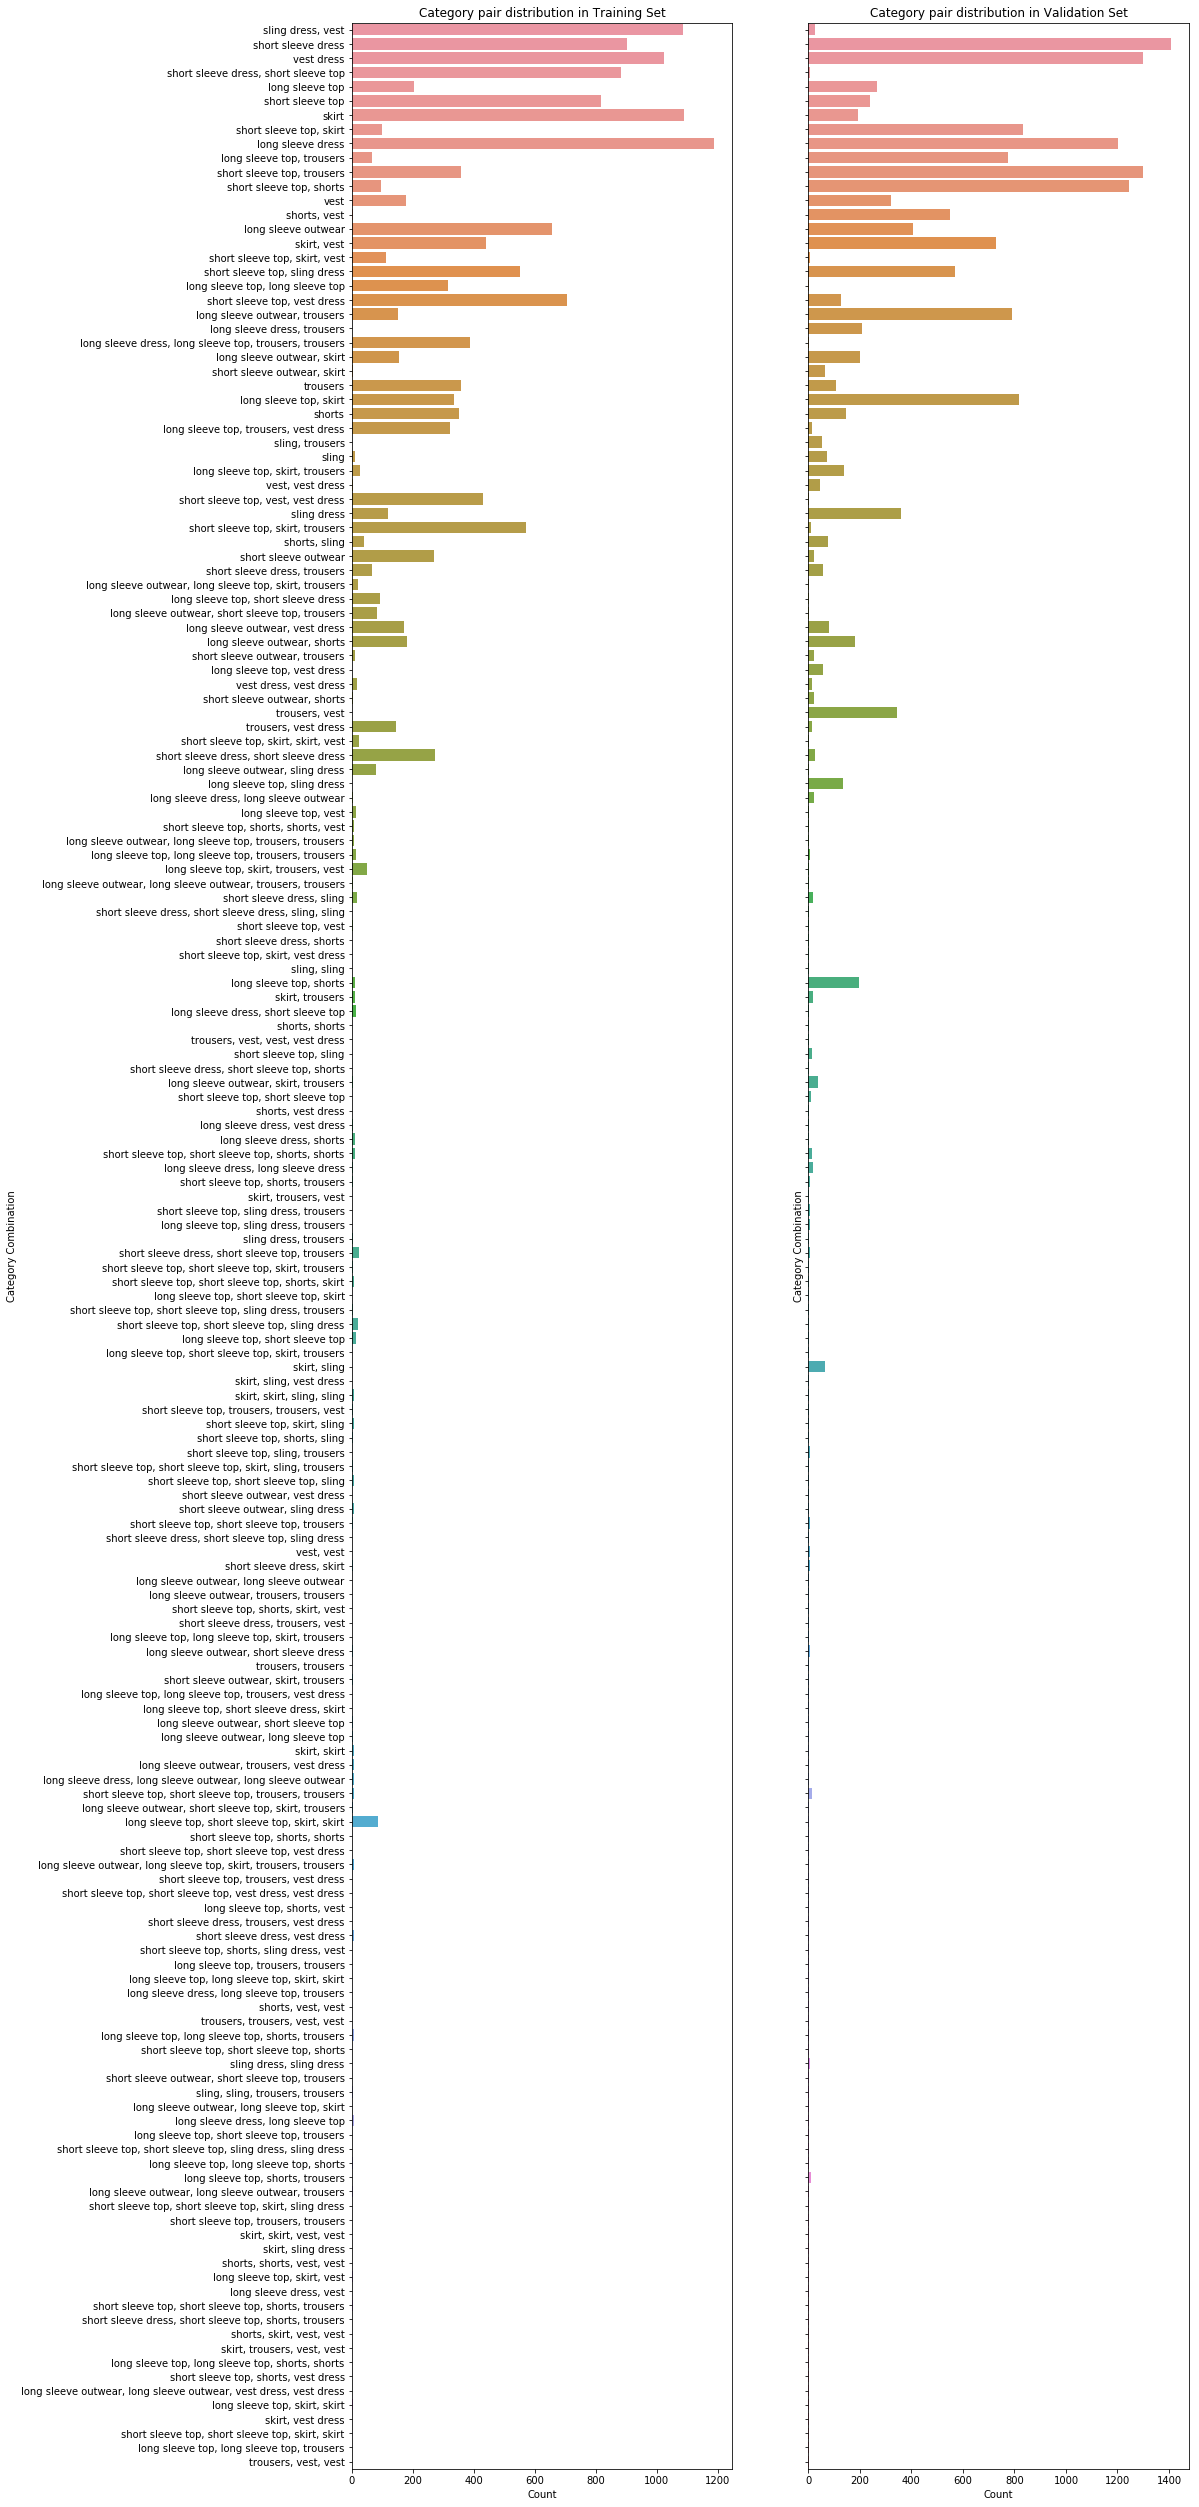

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 45), sharey=True)

combinations_df_train = pd.DataFrame()
combinations_df_validation = pd.DataFrame()

# Count the occurrences of each category combination
combinations_df_train['category_name'] = train_df['category_name']
combinations_df_train['category_combination'] = combinations_df_train['category_name'].apply(lambda x: ', '.join(sorted(x)))
counter = Counter(combinations_df_train['category_combination'])
combinations_df_train = combinations_df_train.join(pd.DataFrame(list(counter.items()), columns=['Category Combination', 'Count']))
sns.barplot(data=combinations_df_train, y='Category Combination', x='Count', ax=axes[0]).set_title('Category pair distribution in Training Set')

combinations_df_validation['category_name'] = validation_df['category_name']
combinations_df_validation['category_combination'] = combinations_df_validation['category_name'].apply(lambda x: ', '.join(sorted(x)))
counter = Counter(combinations_df_validation['category_combination'])
combinations_df_validation = combinations_df_validation.join(pd.DataFrame(list(counter.items()), columns=['Category Combination', 'Count']))
sns.barplot(data=combinations_df_validation, y='Category Combination', x='Count', ax=axes[1]).set_title('Category pair distribution in Validation Set')

plt.show()

In [14]:
validation_df, test_df = train_test_split(validation_df, test_size=0.50, random_state=42) 

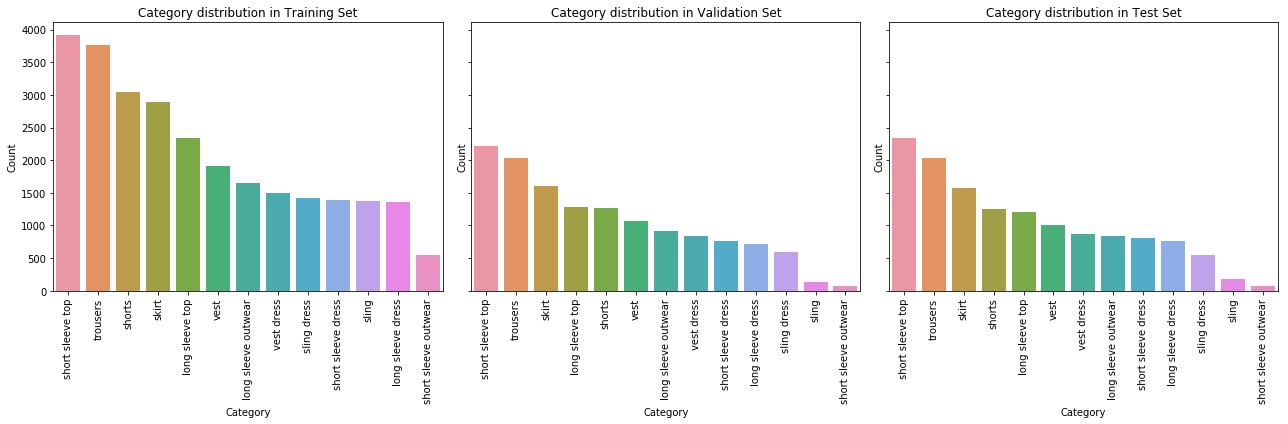

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

categories = [category for sublist in train_df['category_name'] for category in sublist]
counter = Counter(categories)
categories = pd.DataFrame(list(counter.items()), columns=['Category', 'Count'])
sns.barplot(data=categories, x='Category', y='Count', ax=axes[0], order=categories.sort_values('Count',ascending = False).Category).set_title('Category distribution in Training Set')
axes[0].tick_params('x', labelrotation=90)

categories = [category for sublist in validation_df['category_name'] for category in sublist]
counter = Counter(categories)
categories = pd.DataFrame(list(counter.items()), columns=['Category', 'Count'])
sns.barplot(data=categories, x='Category', y='Count', ax=axes[1], order=categories.sort_values('Count',ascending = False).Category).set_title('Category distribution in Validation Set')
axes[1].tick_params('x', labelrotation=90)

categories = [category for sublist in test_df['category_name'] for category in sublist]
counter = Counter(categories)
categories = pd.DataFrame(list(counter.items()), columns=['Category', 'Count'])
sns.barplot(data=categories, x='Category', y='Count', ax=axes[2], order=categories.sort_values('Count',ascending = False).Category).set_title('Category distribution in Test Set')
axes[2].tick_params('x', labelrotation=90)

plt.tight_layout()
plt.show()

In [16]:
if len(validation_df)%2 != 0:
    random_index = validation_df.sample(n=1).index
    validation_df = validation_df.drop(random_index)
    
    
if len(train_df)%2 != 0:
    random_index = train_df.sample(n=1).index
    train_df = train_df.drop(random_index)
    
if len(test_df)%2 != 0:
    random_index = test_df.sample(n=1).index
    test_df = test_df.drop(random_index)
    
    
    
print(len(validation_df))
print(len(train_df))
print(len(test_df))

8132
16118
8132


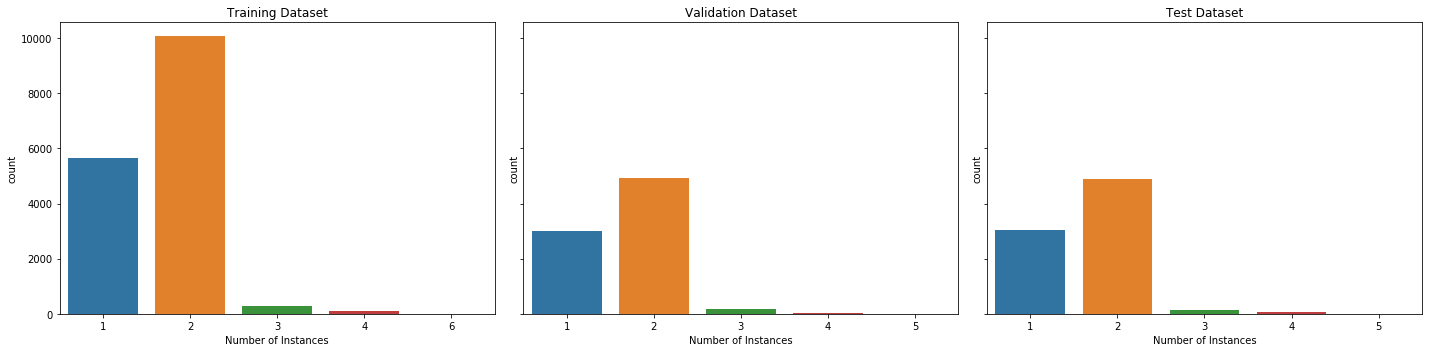

In [17]:
num_instances_train = train_df['category_id'].apply(len).tolist()
num_instances_validation = validation_df['category_id'].apply(len).tolist()
num_instances_test = test_df['category_id'].apply(len).tolist()

fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True, tight_layout=True)

sns.countplot(x=num_instances_train, ax=axs[0]).set_title('Training Dataset')
axs[0].set_xlabel('Number of Instances')

sns.countplot(x=num_instances_validation, ax=axs[1]).set_title('Validation Dataset')
axs[1].set_xlabel('Number of Instances')

sns.countplot(x=num_instances_test, ax=axs[2]).set_title('Test Dataset')
axs[2].set_xlabel('Number of Instances')

plt.show()

# Create Dataset & Config

In [18]:
# Target Image Dimensions which are divisable by 64 as required by the MASK-RCNN model
HEIGHT_TARGET = 256
WIDTH_TARGET = 256
SHAPE_TARGET = (HEIGHT_TARGET, WIDTH_TARGET)

In [19]:
class ClothDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__()
        self.df = df

    def load_dataset(self):
        categories = ["short sleeve top", "long sleeve top", "short sleeve outwear", "long sleeve outwear", "vest", "sling", 
                      "shorts", "trousers", "skirt", "short sleeve dress", "long sleeve dress", "vest dress", "sling dress"]
        for index, category in enumerate(categories):
            self.add_class("fashion", index+1, category.lower())
            
        for vertical_flip in [True, False]:
            for horizontal_flip in [True, False]:
                for index, row in self.df.iterrows():
                    self.add_image('fashion', 
                                   image_id=index, 
                                   path=row['path'], 
                                   bounding_box=row['b_box'], 
                                   segmentation=row['segmentation'],
                                   category_name=row['category_name'], 
                                   category_id=row['category_id'],
                                   img_height=row['img_height'],
                                   img_width=row['img_width'],
                                   vertical_flip=vertical_flip, 
                                   horizontal_flip=horizontal_flip)
            
    def extract_boxes(self, image_id):
        image_info = self.image_info[image_id]
        boxes = np.array(image_info['bounding_box'])  # Convert to numpy array
        category_names = image_info['category_name']
        return boxes, category_names, image_info['img_width'], image_info['img_height']

    def load_mask(self, image_id):
        info = self.image_info[image_id]
    
        img_width = info['img_width']
        img_height = info['img_height']

        mask_list = info['segmentation']

        # Initialize an empty mask with all zeros
        masks = np.zeros([img_height, img_width, len(mask_list)], dtype='uint8')

        # For each mask in the mask_list
        for i, masks_per_instance in enumerate(mask_list):
            # Masks for each instance could be multiple in case an instance has disjoint parts; combine them into a single mask here.
            full_mask = np.zeros([img_height, img_width], dtype='uint8')
            for seg_mask in masks_per_instance:
                rr, cc = polygon(seg_mask[1::2], seg_mask[0::2], (img_height, img_width))
                full_mask[rr, cc] = 1
            masks[:, :, i] = full_mask

        # Convert the list of category IDs into an array
        class_ids = np.array(info['category_id'], dtype='int32')
        return masks, class_ids

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

/kaggle/input/deepfashion2-256x256/resized/train/130118.jpg
/kaggle/input/deepfashion2-256x256/resized/train/172727.jpg
/kaggle/input/deepfashion2-256x256/resized/train/191011.jpg
/kaggle/input/deepfashion2-256x256/resized/train/033122.jpg
/kaggle/input/deepfashion2-256x256/resized/train/076251.jpg


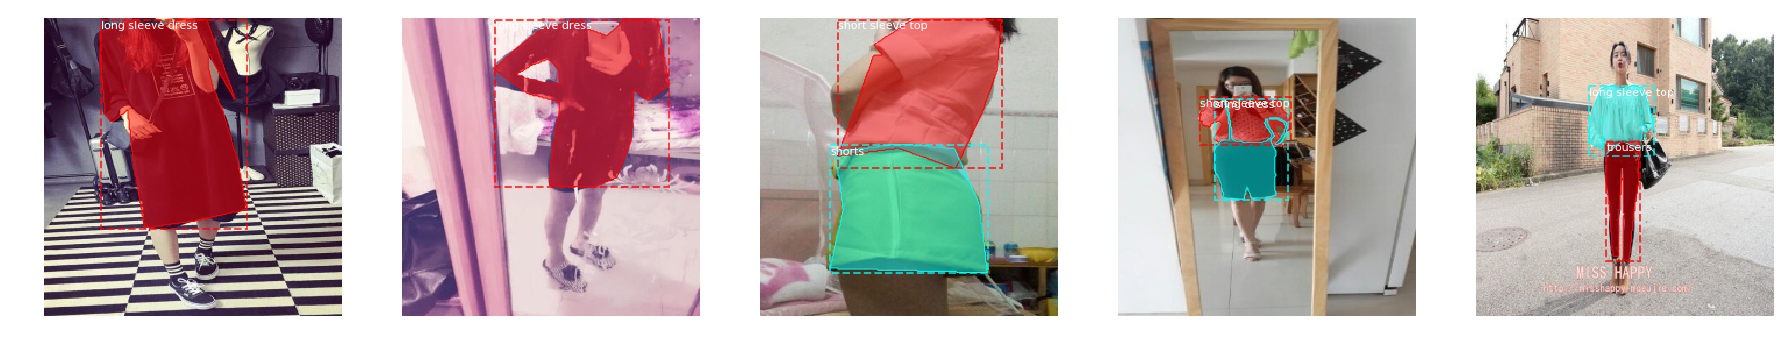

In [20]:
dataset = ClothDataset(train_df)
dataset.load_dataset()
dataset.prepare()

plt.figure(figsize=(25, 80))
for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    image_id = random.choice(dataset.image_ids)
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    print(dataset.image_reference(image_id))
    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, ax=ax)

plt.tight_layout()
plt.show()

In [21]:
DATASET_LENGTH = len(train_df)
MAX_BATCH = 2
BATCH_SIZE = sorted([int(DATASET_LENGTH/n) for n in range(1,DATASET_LENGTH+1) if DATASET_LENGTH % n ==0 and DATASET_LENGTH/n<=MAX_BATCH],reverse=True)[0]  
STEPS = int(DATASET_LENGTH/BATCH_SIZE)
STEPS

8059

In [22]:
VAL_DATASET_LENGTH = len(validation_df)
MAX_BATCH = 2
VAL_BATCH_SIZE = sorted([int(VAL_DATASET_LENGTH/n) for n in range(1,VAL_DATASET_LENGTH+1) if VAL_DATASET_LENGTH % n ==0 and VAL_DATASET_LENGTH/n<=MAX_BATCH],reverse=True)[0]  
VAL_STEPS = int(VAL_DATASET_LENGTH/VAL_BATCH_SIZE)
VAL_STEPS

4066

In [23]:
class ClothConfig(Config):
    # name of the configuration
    NAME = "fashion_config"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    STEPS_PER_EPOCH = STEPS
    VALIDATION_STEPS = VAL_STEPS
    
    # Number of Classes
    NUM_CLASSES = 1 + 13

    # Image Dimensions
    IMAGE_MIN_DIM = HEIGHT_TARGET
    IMAGE_MAX_DIM = WIDTH_TARGET
    IMAGE_SHAPE = [HEIGHT_TARGET, WIDTH_TARGET, 3]
    IMAGE_RESIZE_MODE = 'square'
    BACKBONE = 'resnet50'
    
    TRAIN_BN = False
    
    # Learning Rate
    LEARNING_RATE = 0.0001
    WEIGHT_DECAY = 0.0
    
    # Dataloader Queue Size (was set to 100 but resulted in OOM error)
    MAX_QUEUE_SIZE = 3
    
    # Debug mode will disable model checkpoints
    DEBUG = False
    
    # Do not use multithreading as this slows down the dataloader!
    WORKERS = 0
    
    # Losses
    LOSS_WEIGHTS = {
        'rpn_class_loss': 1.0,    # is the class of the bbox correct? / RPN anchor classifier loss (Forground/Background)
        'rpn_bbox_loss': 1.0,     # is the size of the bbox correct? / RPN bounding box loss graph (bbox of generic object)
        'mrcnn_class_loss': 1.0,  # loss for the classifier head of Mask R-CNN (Background / specific class)
        'mrcnn_bbox_loss': 1.0,   # is the size of the bounding box correct or not? / loss for Mask R-CNN bounding box refinement
        'mrcnn_mask_loss': 1.0,   # is the class correct? is the pixel correctly assign to the class? / mask binary cross-entropy loss for the masks head
    }
    
    # Training Structure
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    
    # Regions of Interest
    PRE_NMS_LIMIT = 2000
    
    # Non Max Supression
    POST_NMS_ROIS_TRAINING = 600
    POST_NMS_ROIS_INFERENCE = 600
    
    # Instances
    MAX_GT_INSTANCES = 2
    TRAIN_ROIS_PER_IMAGE = 100
    DETECTION_MAX_INSTANCES = 3
    
    # Thresholds
    RPN_NMS_THRESHOLD = 0.70        # IoU Threshold for RPN proposals and GT
    DETECTION_MIN_CONFIDENCE = 0.50 # Non-Background Confidence Threshold
    DETECTION_NMS_THRESHOLD = 0.30  # IoU Threshold for ROI and GT
    ROI_POSITIVE_RATIO = 0.33
    
    
config = ClothConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DEBUG                          False
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                26
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE        

# Train

In [24]:
# training set
training_data = ClothDataset(train_df)
training_data.load_dataset()
training_data.prepare()

# validation set
validation_data = ClothDataset(validation_df)
validation_data.load_dataset()
validation_data.prepare()

# load fashion config
config = ClothConfig()

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [ ]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5) # only horizontal flip here
])

## Initially training only the heads

In [ ]:
start_train = time.time()
model.train(train_dataset=training_data, 
            val_dataset=validation_data, 
            learning_rate=config.LEARNING_RATE*2, 
            layers='heads',
            epochs=3,
            augmentation=None)
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training heads took {minutes} minutes')

history = model.keras_model.history.history

## Training all

In [ ]:
start_train = time.time()
model.train(train_dataset=training_data, 
            val_dataset=validation_data, 
            learning_rate=config.LEARNING_RATE, 
            layers='all',
            epochs=9,
            augmentation=augmentation)
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training all took {minutes} minutes')

new_history = model.keras_model.history.history
for k in new_history: 
    history[k] = history[k] + new_history[k]

## Train again

In [ ]:
start_train = time.time()
model.train(train_dataset=training_data, 
            val_dataset=validation_data, 
            learning_rate=config.LEARNING_RATE/5, 
            layers='all',
            epochs=12,
            augmentation=augmentation)
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training all took {minutes} minutes')

new_history = model.keras_model.history.history
for k in new_history: 
    history[k] = history[k] + new_history[k]

In [ ]:
np.save('/kaggle/working/history_resnet50.npy', history)

# Evaluation

In [25]:
history = np.load("/kaggle/input/resnet50-training/history_resnet50.npy", allow_pickle=True).item()

In [26]:
# Function to plot metrics
def plot_history_metric(ax, metric, f_best=np.argmax):
    values = history[metric]
    N_EPOCHS = len(values)
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]
    x_ticks = np.arange(1, N_EPOCHS+1)
    
    ax.plot(x_ticks, values, label='train')
    argmin = f_best(values)
    ax.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label='train_best')
    ax.set_ylabel(metric, fontsize=15, labelpad=10)
    ax.set_xlabel('epoch', fontsize=15, labelpad=10)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xticks(x) # set tick step to 1 and let x axis start at 1
    ax.legend(prop={'size': 15})

In [27]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

Best epoch:  18
Valid loss:  0.8230027692933236


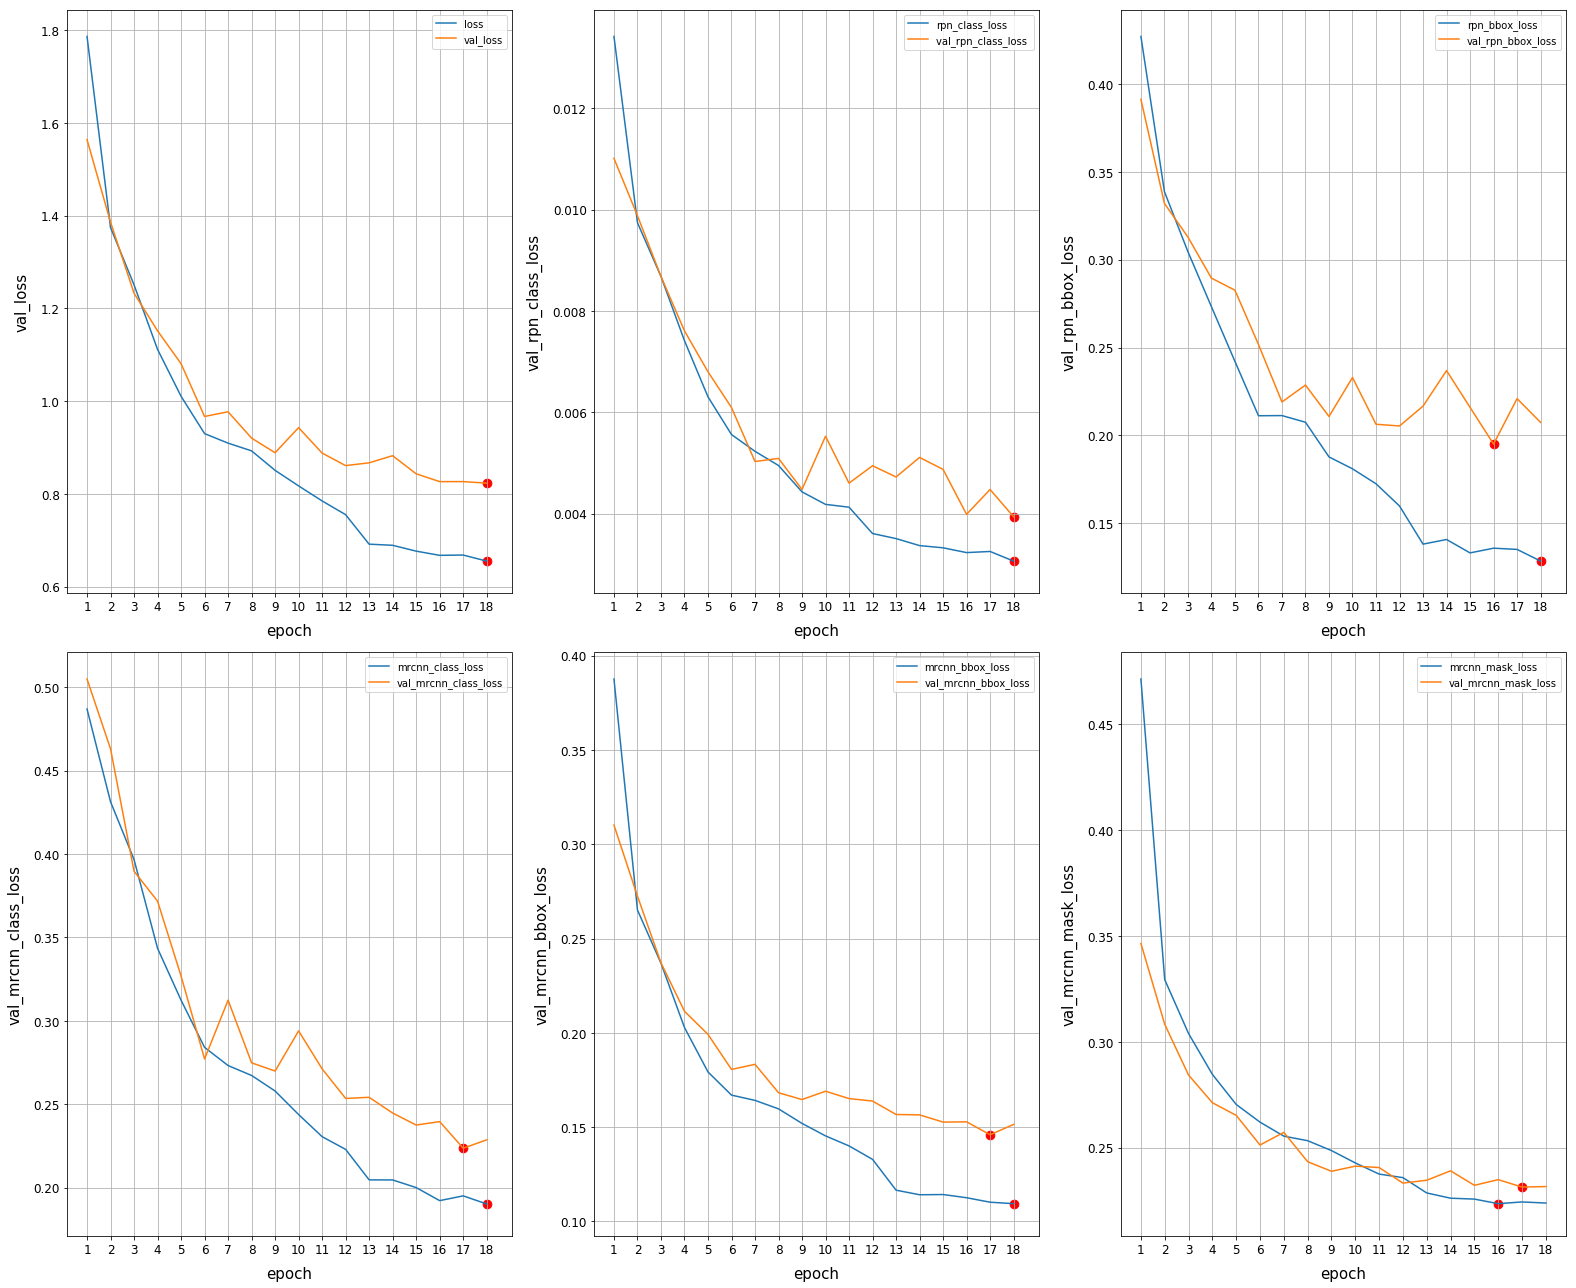

In [28]:
fig, axs = plt.subplots(2, 3, figsize=(22,18))
plot_history_metric(axs[0, 0], 'loss', f_best=np.argmin)
plot_history_metric(axs[0, 1], 'rpn_class_loss', f_best=np.argmin)
plot_history_metric(axs[0, 2], 'rpn_bbox_loss', f_best=np.argmin)
plot_history_metric(axs[1, 0], 'mrcnn_class_loss', f_best=np.argmin)
plot_history_metric(axs[1, 1], 'mrcnn_bbox_loss', f_best=np.argmin)
plot_history_metric(axs[1, 2], 'mrcnn_mask_loss', f_best=np.argmin)

plot_history_metric(axs[0, 0], 'val_loss', f_best=np.argmin)
plot_history_metric(axs[0, 1], 'val_rpn_class_loss', f_best=np.argmin)
plot_history_metric(axs[0, 2], 'val_rpn_bbox_loss', f_best=np.argmin)
plot_history_metric(axs[1, 0], 'val_mrcnn_class_loss', f_best=np.argmin)
plot_history_metric(axs[1, 1], 'val_mrcnn_bbox_loss', f_best=np.argmin)
plot_history_metric(axs[1, 2], 'val_mrcnn_mask_loss', f_best=np.argmin)

axs[0, 0].legend(['loss', 'val_loss'])
axs[0, 0].grid()

axs[0, 1].legend(['rpn_class_loss', 'val_rpn_class_loss '])
axs[0, 1].grid()

axs[0, 2].legend(['rpn_bbox_loss', 'val_rpn_bbox_loss'])
axs[0, 2].grid()

axs[1, 0].legend(['mrcnn_class_loss', 'val_mrcnn_class_loss'])
axs[1, 0].grid()

axs[1, 1].legend(['mrcnn_bbox_loss', 'val_mrcnn_bbox_loss'])
axs[1, 1].grid()

axs[1, 2].legend(['mrcnn_mask_loss', 'val_mrcnn_mask_loss'])
axs[1, 2].grid()


fig.tight_layout()
fig.show() 

# Predict & Evaluate

In [29]:
glob_list = glob.glob(f'/kaggle/working/fashion*/mask_rcnn_fashion_config_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''

In [30]:
model_path = "/kaggle/input/resnet50-training/mask_rcnn_fashion_config_0018.h5"

In [31]:
DATASET_LENGTH = len(test_df)
MAX_BATCH = 1
BATCH_SIZE = sorted([int(DATASET_LENGTH/n) for n in range(1,DATASET_LENGTH+1) if DATASET_LENGTH % n ==0 and DATASET_LENGTH/n<=MAX_BATCH],reverse=True)[0]  
STEPS = int(DATASET_LENGTH/BATCH_SIZE)
STEPS

8132

In [32]:
class InferenceConfig(ClothConfig):
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.50
    USE_MINI_MASK = False
    STEPS_PER_EPOCH = STEPS
    DETECTION_MAX_INSTANCES = 1

inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DEBUG                          False
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                26
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE        

In [33]:
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

assert model_path != '', "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loading weights from  /kaggle/input/resnet50-training/mask_rcnn_fashion_config_0018.h5


In [34]:
# validation set
testing_data = ClothDataset(test_df)
testing_data.load_dataset()
testing_data.prepare()

## Visualising some predictions


*** No instances to display *** 



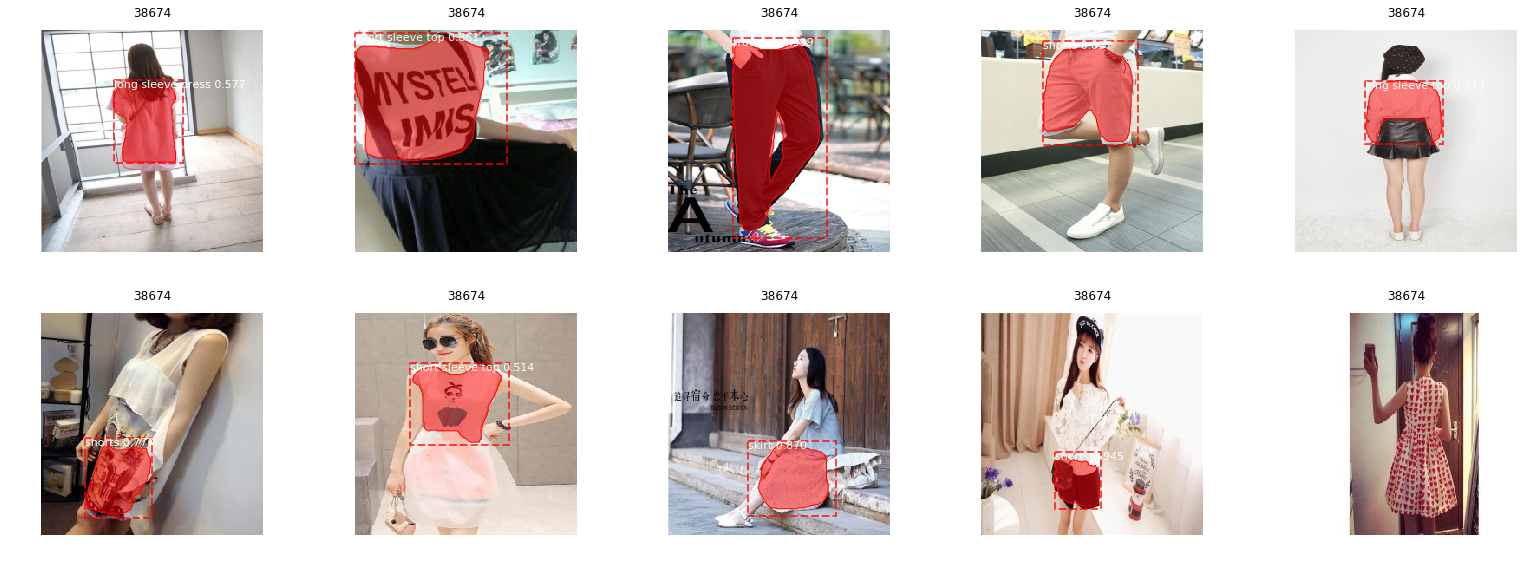

In [35]:
label_names = ["short sleeve top", "long sleeve top", "short sleeve outwear", "long sleeve outwear", "vest", "sling", 
              "shorts", "trousers", "skirt", "short sleeve dress", "long sleeve dress", "vest dress", "sling dress"]
fig, axs = plt.subplots(figsize=(22, 8))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    image_path = test_df.sample()['path'].values[0]
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([img])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/256
        x_scale = img.shape[1]/256
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, ax=ax)

    
plt.tight_layout()    
plt.show()

## Predicted vs Actual

In [36]:
def plot_actual_vs_predicted(dataset, model, config, n_images):
    image_ids = np.random.choice(dataset.image_ids, n_images)
    fig, axs = plt.subplots(figsize=(30, 15))
    for i, image_id in enumerate(image_ids):
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config, image_id)
        info = dataset.image_info[image_id]
        print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                               dataset.image_reference(image_id)))
        print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

        # Run object detection
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        results = model.detect([image], verbose=0)
#         results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

        # Display results
        r = results[0]
        log("gt_class_id", gt_class_id)
        log("gt_bbox", gt_bbox)
        log("gt_mask", gt_mask)

        # Compute AP over range 0.5 to 0.95 and print it
        utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                               r['rois'], r['class_ids'], r['scores'], r['masks'],
                               verbose=1)
        
        ax = plt.subplot(2, 5, i+1)
        visualize.display_differences(
            image,
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            dataset.class_names,
            show_box=False, show_mask=False, ax = ax,
            iou_threshold=0.5, score_threshold=0.5)

image ID: fashion.1068 (20427) /kaggle/input/deepfashion2-256x256/resized/validation/002227.jpg
Original image shape:  [256 256   3]
gt_class_id              shape: (1,)                  min:   12.00000  max:   12.00000  int32
gt_bbox                  shape: (1, 4)                min:   68.00000  max:  167.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  uint8
AP @0.50:	 0.000
AP @0.55:	 0.000
AP @0.60:	 0.000
AP @0.65:	 0.000
AP @0.70:	 0.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.000
image ID: fashion.4865 (15090) /kaggle/input/deepfashion2-256x256/resized/validation/010082.jpg
Original image shape:  [256 256   3]
gt_class_id              shape: (2,)                  min:    5.00000  max:    9.00000  int32
gt_bbox                  shape: (2, 4)                min:    4.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 2)         min:    0.00000  m

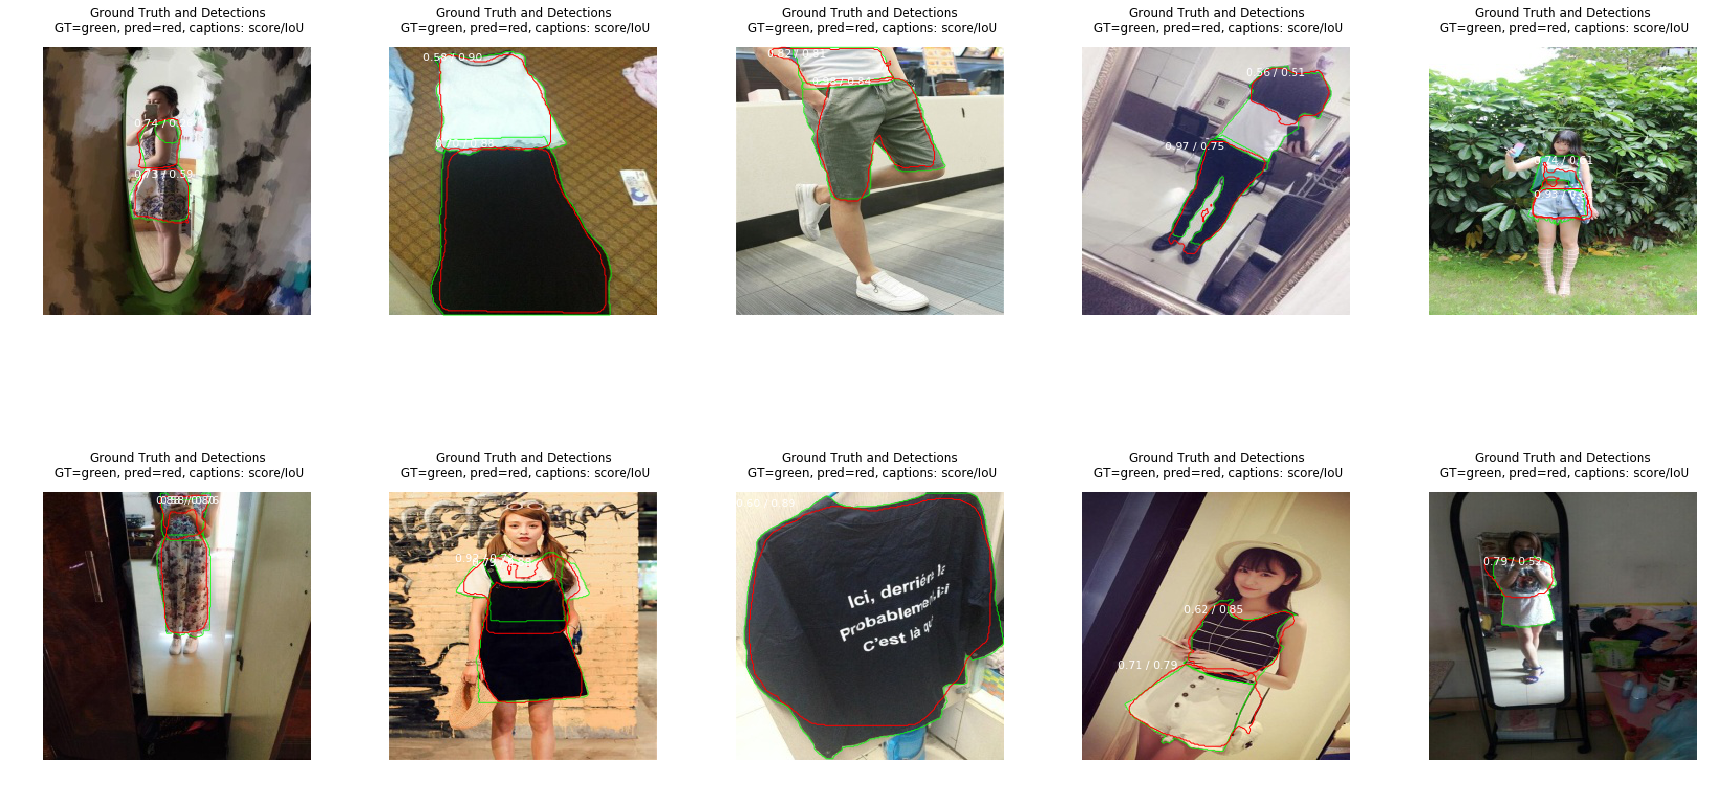

In [37]:
plot_actual_vs_predicted(testing_data, model, inference_config, 10)

## Evaluation mAP

In [36]:
all_scores = []
all_class_ids = []
actual_labels = []
predicted_labels = []
def calculate_mAP(data_loader, threshold=0.5):
    APs = []

    for image_id in tqdm(data_loader.image_ids):
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(data_loader, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)


        results = model.detect([image], verbose=0)
        r = results[0]

        # Calculate mAP
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, 
                                                             r["rois"], r["class_ids"], r["scores"], r['masks'],
                                                             iou_threshold=threshold)
        
        APs.append(AP)
        all_scores.extend(r["scores"])
        all_class_ids.extend(r["class_ids"])
        actual_labels.extend(gt_class_id)
        predicted_labels.extend(r["class_ids"])
        

    print("mAP@IoU{:.2f}: {:.2f}".format(threshold, np.mean(APs)))

In [39]:
calculate_mAP(testing_data)
calculate_mAP(testing_data, 0.65)
calculate_mAP(testing_data, 0.75)
calculate_mAP(testing_data, 0.85)
calculate_mAP(testing_data, 0.95)

  0%|          | 0/32536 [00:00<?, ?it/s]

mAP@IoU0.50: 0.41


  0%|          | 0/32536 [00:00<?, ?it/s]

mAP@IoU0.65: 0.37


  0%|          | 0/32536 [00:00<?, ?it/s]

mAP@IoU0.75: 0.30


  0%|          | 0/32536 [00:00<?, ?it/s]

mAP@IoU0.85: 0.13


100%|██████████| 32536/32536 [54:12<00:00, 10.94it/s] 


mAP@IoU0.95: 0.00


In [ ]:
calculate_mAP(testing_data)

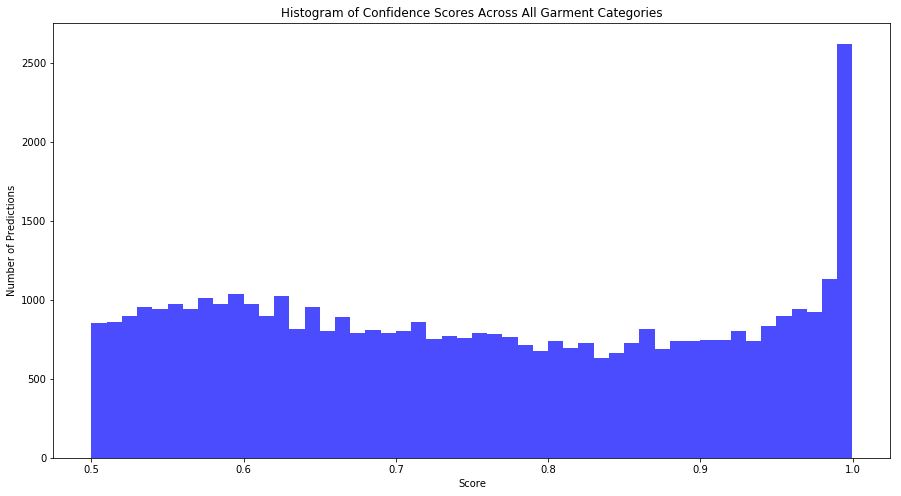

In [47]:
# Histogram of confidence intervals
fig, axs = plt.subplots(figsize=(15, 8))
plt.hist(all_scores, bins=50, facecolor='blue', alpha=0.7)
plt.title('Histogram of Confidence Scores Across All Garment Categories')
plt.xlabel('Score')
plt.ylabel('Number of Predictions')
plt.show()

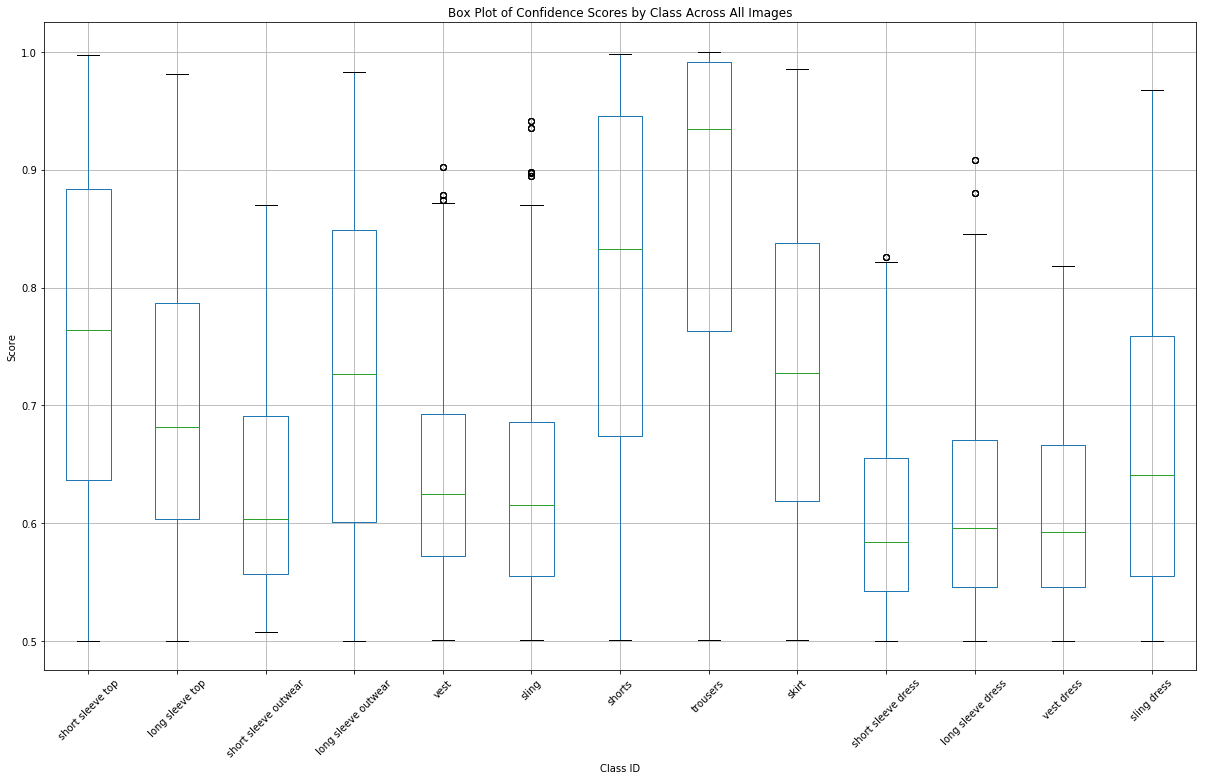

In [55]:
boxprops = dict(linestyle='-', linewidth=4, color='b')
medianprops = dict(linestyle='-', linewidth=4, color='r')

df = pd.DataFrame({
    'Scores': all_scores,
    'Class': all_class_ids
})

df.boxplot(column='Scores', by='Class', showmeans=True,
           whiskerprops=dict(linestyle='-', linewidth=1.5), 
           capprops=dict(linestyle='-', linewidth=1.5),
           boxprops=boxprops, medianprops=medianprops, figsize=(20, 12))
plt.title('Box Plot of Confidence Scores by Class Across All Images')
plt.suptitle('')  # Suppress the default title
plt.xticks(range(1, 14), labels=["short sleeve top", "long sleeve top", "short sleeve outwear", "long sleeve outwear", "vest", "sling", 
                 "shorts", "trousers", "skirt", "short sleeve dress", "long sleeve dress", "vest dress", "sling dress"], rotation=45)
plt.xlabel('Class ID')
plt.ylabel('Score')
plt.show()

## mAP@ for different garment categories

### Confusion matrix for images with only one garment

In [37]:
all_scores = []
all_class_ids = []
actual_labels = []
predicted_labels = []
def calculate_mAP_conf(data_loader, threshold=0.5):
    APs = []

    for image_id in tqdm(data_loader.image_ids):
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(data_loader, inference_config,
                                   image_id)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)


        results = model.detect([image], verbose=0)
        r = results[0]

        # Calculate mAP
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, 
                                                             r["rois"], r["class_ids"], r["scores"], r['masks'],
                                                             iou_threshold=threshold)
        
        APs.append(AP)
        if len(r["class_ids"]) == 1 and r["class_ids"][0] != 0:
            all_scores.append(r["scores"][0])
            all_class_ids.append(r["class_ids"][0])
            actual_labels.extend(gt_class_id)
            predicted_labels.append(r["class_ids"][0])

    print("mAP@IoU{:.2f}: {:.2f}".format(threshold, np.mean(APs)))

In [32]:
def filter_single_garment_rows(df):
    """Filter rows of a DataFrame that have only one garment."""
    return df[df['category_name'].apply(lambda x: len(x) == 1)]

In [33]:
filtered_df = filter_single_garment_rows(test_df)
filtered_data = ClothDataset(filtered_df)
filtered_data.load_dataset()
filtered_data.prepare()

calculate_mAP_conf(filtered_data)

100%|██████████| 11944/11944 [17:48<00:00, 11.18it/s]

mAP@IoU0.50: 0.19


In [34]:
def plot_confidence_matrix(actual_labels, predicted_labels, all_scores, class_names):
    n_classes = len(class_names)
    
    # Initialize confusion matrix with zeros
    confidence_matrix = np.zeros((n_classes, n_classes))
    count_matrix = np.zeros((n_classes, n_classes))
    
    # Populate the matrix
    for i in range(len(predicted_labels)):
        confidence_matrix[actual_labels[i], predicted_labels[i]] += all_scores[i]
        count_matrix[actual_labels[i], predicted_labels[i]] += 1
    
    # Normalize the matrix
    confidence_matrix = np.divide(confidence_matrix, count_matrix, out=np.zeros_like(confidence_matrix), where=count_matrix!=0)
    
    mask = np.ones_like(confidence_matrix, dtype=bool)
    mask[confidence_matrix.argmax(axis=0), np.arange(n_classes)] = False
    
    # Plot the matrix
    plt.figure(figsize=(20, 12))
    ax = sns.heatmap(confidence_matrix, annot=True, cmap="Reds", cbar=False, mask=mask,
                     xticklabels=class_names, yticklabels=class_names)
    sns.heatmap(confidence_matrix, annot=True, cmap="Blues", cbar=False, mask=~mask, vmin=0.52,
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    plt.xlabel('Actual labels')
    plt.ylabel('Predicted labels')
    plt.show()

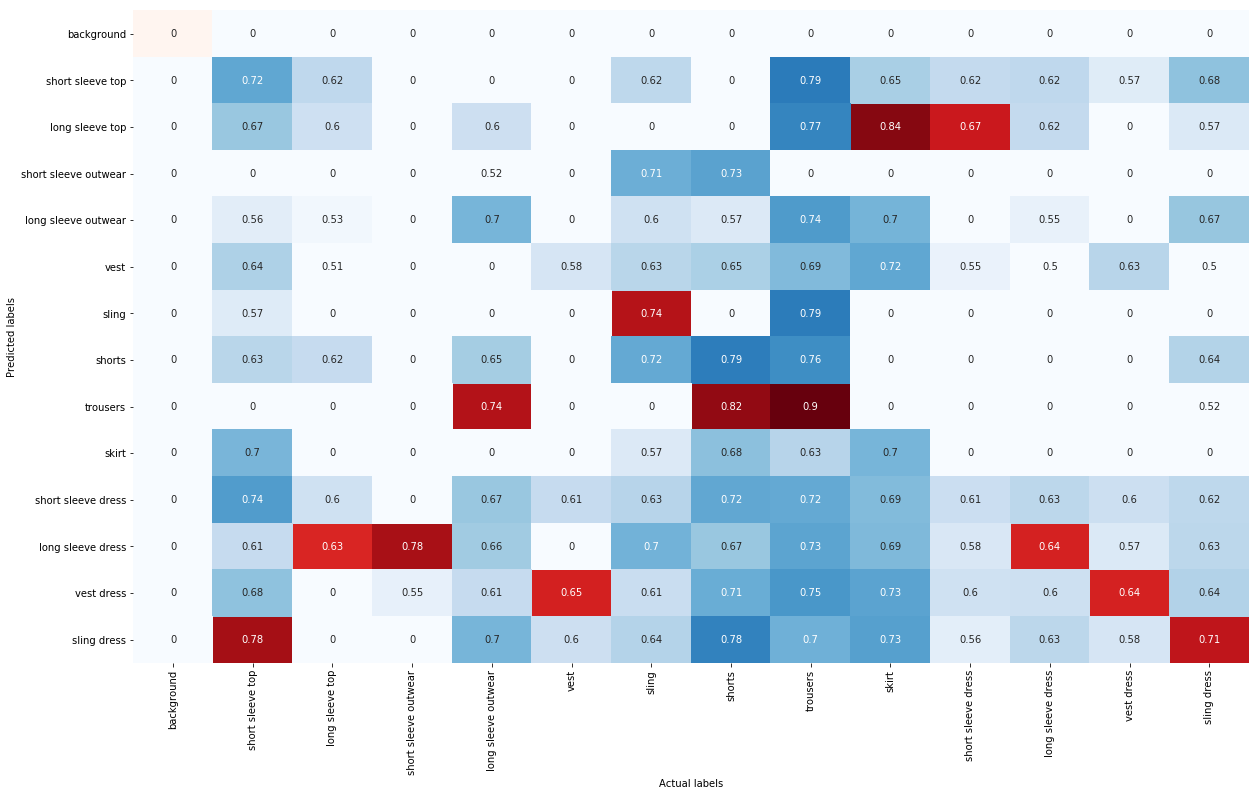

In [35]:
plot_confidence_matrix(actual_labels, predicted_labels, all_scores, ["background", "short sleeve top", "long sleeve top", "short sleeve outwear", "long sleeve outwear", "vest", "sling", 
                 "shorts", "trousers", "skirt", "short sleeve dress", "long sleeve dress", "vest dress", "sling dress"])

### Images with one category only

In [38]:
def filter_by_category_name(df, category):
    """Filter rows of a DataFrame where 'category_name' column contains only the specified category."""
    return df[df['category_name'].apply(lambda x: x == [category])]

In [39]:
for category in ["short sleeve top", "long sleeve top", "short sleeve outwear", "long sleeve outwear", "vest", "sling", 
                 "shorts", "trousers", "skirt", "short sleeve dress", "long sleeve dress", "vest dress", "sling dress"]:
    filtered_df = filter_by_category_name(test_df, category)
    filtered_data = ClothDataset(filtered_df)
    filtered_data.load_dataset()
    filtered_data.prepare()
    print("\n\nEvaluation for images with only " + category)
    calculate_mAP(filtered_data)
    calculate_mAP(filtered_data, 0.75)

  0%|          | 2/528 [00:00<00:42, 12.43it/s]



Evaluation for images with only short sleeve top


  0%|          | 2/528 [00:00<00:33, 15.71it/s]

mAP@IoU0.50: 0.23


  0%|          | 0/548 [00:00<?, ?it/s]

mAP@IoU0.75: 0.17


Evaluation for images with only long sleeve top


  0%|          | 2/548 [00:00<00:37, 14.57it/s]

mAP@IoU0.50: 0.07


  5%|▌         | 2/40 [00:00<00:03, 12.59it/s]

mAP@IoU0.75: 0.07


Evaluation for images with only short sleeve outwear


  2%|▎         | 1/40 [00:00<00:04,  8.29it/s]

mAP@IoU0.50: 0.00


100%|██████████| 40/40 [00:03<00:00, 12.53it/s]


mAP@IoU0.75: 0.00


  0%|          | 2/744 [00:00<00:54, 13.67it/s]



Evaluation for images with only long sleeve outwear


  0%|          | 2/744 [00:00<00:48, 15.19it/s]

mAP@IoU0.50: 0.36


  0%|          | 0/652 [00:00<?, ?it/s]

mAP@IoU0.75: 0.20


Evaluation for images with only vest


  0%|          | 2/652 [00:00<00:40, 15.89it/s]

mAP@IoU0.50: 0.04


  1%|          | 2/180 [00:00<00:10, 16.99it/s]

mAP@IoU0.75: 0.04


Evaluation for images with only sling


  1%|          | 2/180 [00:00<00:09, 19.63it/s]

mAP@IoU0.50: 0.38


  0%|          | 0/276 [00:00<?, ?it/s]

mAP@IoU0.75: 0.27


Evaluation for images with only shorts


  0%|          | 1/276 [00:00<00:28,  9.51it/s]

mAP@IoU0.50: 0.39


  0%|          | 0/224 [00:00<?, ?it/s]

mAP@IoU0.75: 0.36


Evaluation for images with only trousers


  0%|          | 1/224 [00:00<00:25,  8.61it/s]

mAP@IoU0.50: 0.77


  0%|          | 0/388 [00:00<?, ?it/s]

mAP@IoU0.75: 0.70


Evaluation for images with only skirt


  1%|          | 2/388 [00:00<00:23, 16.09it/s]

mAP@IoU0.50: 0.11


100%|██████████| 388/388 [00:31<00:00, 12.34it/s]


mAP@IoU0.75: 0.10


  0%|          | 2/2872 [00:00<03:45, 12.75it/s]



Evaluation for images with only short sleeve dress


  0%|          | 2/2872 [00:00<04:06, 11.67it/s]

mAP@IoU0.50: 0.10


100%|██████████| 2872/2872 [04:05<00:00, 12.09it/s]


mAP@IoU0.75: 0.09


  0%|          | 2/2432 [00:00<02:23, 16.96it/s]



Evaluation for images with only long sleeve dress


  0%|          | 2/2432 [00:00<03:08, 12.90it/s]

mAP@IoU0.50: 0.22


100%|██████████| 2432/2432 [03:25<00:00, 11.11it/s]


mAP@IoU0.75: 0.20


  0%|          | 2/2624 [00:00<03:11, 13.67it/s]



Evaluation for images with only vest dress


  0%|          | 2/2624 [00:00<02:35, 16.86it/s]

mAP@IoU0.50: 0.23


  0%|          | 0/644 [00:00<?, ?it/s]

mAP@IoU0.75: 0.21


Evaluation for images with only sling dress


  0%|          | 2/644 [00:00<00:44, 14.48it/s]

mAP@IoU0.50: 0.10


100%|██████████| 644/644 [00:51<00:00, 12.61it/s]

mAP@IoU0.75: 0.08


### Images with atleast one category

In [59]:
def filter_by_category_name(df, category):
    """Filter rows of a DataFrame where 'category_name' column contains the specified category."""
    return df[df['category_name'].apply(lambda x: category in x)]

In [60]:
for category in ["short sleeve top", "long sleeve top", "short sleeve outwear", "long sleeve outwear", "vest", "sling", 
                 "shorts", "trousers", "skirt", "short sleeve dress", "long sleeve dress", "vest dress", "sling dress"]:
    filtered_df = filter_by_category_name(test_df, category)
    filtered_data = ClothDataset(filtered_df)
    filtered_data.load_dataset()
    filtered_data.prepare()
    print("\n\nEvaluation for images with atleast one " + category)
    calculate_mAP(filtered_data)
    calculate_mAP(filtered_data, 0.75)
    calculate_mAP(filtered_data, 0.95)

  0%|          | 2/9220 [00:00<11:41, 13.14it/s]



Evaluation for images with atleast one: short sleeve top


  0%|          | 2/9220 [00:00<15:11, 10.12it/s]

mAP@IoU0.50: 0.62


  0%|          | 2/9220 [00:00<14:38, 10.49it/s]

mAP@IoU0.75: 0.48


100%|██████████| 9220/9220 [16:31<00:00,  9.30it/s]


mAP@IoU0.95: 0.00


  0%|          | 2/4968 [00:00<05:21, 15.43it/s]



Evaluation for images with atleast one: long sleeve top


  0%|          | 1/4968 [00:00<09:45,  8.48it/s]

mAP@IoU0.50: 0.42


  0%|          | 1/4968 [00:00<09:52,  8.38it/s]

mAP@IoU0.75: 0.31


  0%|          | 0/268 [00:00<?, ?it/s]

mAP@IoU0.95: 0.00


Evaluation for images with atleast one: short sleeve outwear


  1%|          | 2/268 [00:00<00:23, 11.10it/s]

mAP@IoU0.50: 0.33


  1%|          | 2/268 [00:00<00:23, 11.50it/s]

mAP@IoU0.75: 0.19


100%|██████████| 268/268 [00:27<00:00,  9.15it/s]


mAP@IoU0.95: 0.00


  0%|          | 2/3536 [00:00<04:49, 12.21it/s]



Evaluation for images with atleast one: long sleeve outwear


  0%|          | 1/3536 [00:00<06:06,  9.66it/s]

mAP@IoU0.50: 0.52


  0%|          | 1/3536 [00:00<06:38,  8.88it/s]

mAP@IoU0.75: 0.20


100%|██████████| 3536/3536 [06:10<00:00,  8.25it/s]


mAP@IoU0.95: 0.00


  0%|          | 2/3996 [00:00<06:23, 10.40it/s]



Evaluation for images with atleast one: vest


  0%|          | 0/3996 [00:00<?, ?it/s]

mAP@IoU0.50: 0.33


  0%|          | 2/3996 [00:00<06:03, 10.98it/s]

mAP@IoU0.75: 0.26


  0%|          | 0/604 [00:00<?, ?it/s]

mAP@IoU0.95: 0.00


Evaluation for images with atleast one: sling


  0%|          | 0/604 [00:00<?, ?it/s]

mAP@IoU0.50: 0.27


  0%|          | 2/604 [00:00<01:00, 10.02it/s]

mAP@IoU0.75: 0.17


100%|██████████| 604/604 [00:58<00:00, 10.34it/s]


mAP@IoU0.95: 0.00


  0%|          | 2/4968 [00:00<06:11, 13.35it/s]



Evaluation for images with atleast one: shorts


  0%|          | 1/4968 [00:00<08:18,  9.97it/s]

mAP@IoU0.50: 0.53


  0%|          | 1/4968 [00:00<08:29,  9.74it/s]

mAP@IoU0.75: 0.38


100%|██████████| 4968/4968 [08:47<00:00,  9.41it/s]


mAP@IoU0.95: 0.00


  0%|          | 2/8176 [00:00<11:20, 12.02it/s]



Evaluation for images with atleast one: trousers


  0%|          | 1/8176 [00:00<16:54,  8.06it/s]

mAP@IoU0.50: 0.63


  0%|          | 1/8176 [00:00<17:50,  7.64it/s]

mAP@IoU0.75: 0.40


100%|██████████| 8176/8176 [15:05<00:00,  9.03it/s]


mAP@IoU0.95: 0.00


  0%|          | 2/6284 [00:00<06:22, 16.41it/s]



Evaluation for images with atleast one: skirt


  0%|          | 1/6284 [00:00<12:15,  8.54it/s]

mAP@IoU0.50: 0.46


  0%|          | 1/6284 [00:00<11:42,  8.95it/s]

mAP@IoU0.75: 0.37


100%|██████████| 6284/6284 [10:50<00:00, 10.24it/s]


mAP@IoU0.95: 0.00


  0%|          | 2/3124 [00:00<04:48, 10.82it/s]



Evaluation for images with atleast one: short sleeve dress


  0%|          | 1/3124 [00:00<06:44,  7.71it/s]

mAP@IoU0.50: 0.15


  0%|          | 1/3124 [00:00<05:20,  9.73it/s]

mAP@IoU0.75: 0.13


100%|██████████| 3124/3124 [04:42<00:00, 11.05it/s]


mAP@IoU0.95: 0.00


  0%|          | 2/2856 [00:00<04:01, 11.83it/s]



Evaluation for images with atleast one: long sleeve dress


  0%|          | 1/2856 [00:00<06:00,  7.93it/s]

mAP@IoU0.50: 0.25


  0%|          | 1/2856 [00:00<05:33,  8.56it/s]

mAP@IoU0.75: 0.20


100%|██████████| 2856/2856 [04:16<00:00, 11.14it/s]


mAP@IoU0.95: 0.00


  0%|          | 2/3420 [00:00<03:27, 16.49it/s]



Evaluation for images with atleast one: vest dress


  0%|          | 1/3420 [00:00<06:55,  8.22it/s]

mAP@IoU0.50: 0.20


  0%|          | 1/3420 [00:00<06:42,  8.49it/s]

mAP@IoU0.75: 0.17


100%|██████████| 3420/3420 [05:03<00:00, 11.29it/s]


mAP@IoU0.95: 0.00


  0%|          | 2/2240 [00:00<02:46, 13.43it/s]



Evaluation for images with atleast one: sling dress


  0%|          | 2/2240 [00:00<03:00, 12.38it/s]

mAP@IoU0.50: 0.31


  0%|          | 2/2240 [00:00<03:05, 12.07it/s]

mAP@IoU0.75: 0.21


100%|██████████| 2240/2240 [03:32<00:00, 10.45it/s]

mAP@IoU0.95: 0.00
